In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import osmnx as ox
import networkx as nx
from scipy import spatial
from sklearn.cluster import KMeans

In [4]:
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 18

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [5]:
cal_true_traffics = np.load("cal_true_traffics.npy")
cal_pred_traffics = np.load("cal_pred_traffics.npy")
test_pred_traffics = np.load("test_pred_traffics.npy")

In [6]:
G = ox.graph_from_place("Manhattan, New York City, New York", network_type="drive")

G = ox.add_edge_speeds(G)
G = ox.add_edge_travel_times(G)

edges = ox.graph_to_gdfs(G, nodes=False)
edges["highway"] = edges["highway"].astype(str)
edges.groupby("highway")[["length", "speed_kph", "travel_time"]].mean().round(1)

hwy_speeds = {"residential": 35, "secondary": 50, "tertiary": 60}
G = ox.add_edge_speeds(G, hwy_speeds)
G = ox.add_edge_travel_times(G)

In [7]:
k = 10
alpha = 0.05

c_cal_tiled = np.transpose(np.tile(cal_true_traffics, (k, 1, 1)), (1, 0, 2))
c_cal_diff = cal_pred_traffics - c_cal_tiled
c_cal_norms = np.linalg.norm(c_cal_diff, axis=-1)
c_cal_scores = np.min(c_cal_norms, axis=-1)

conformal_quantile = np.quantile(c_cal_scores, q = 1 - alpha)

In [8]:
def get_rps_cc(N_rps, regions_samples):
    total_covered = np.sum([len(region_samples) for region_samples in regions_samples])
    total_rps = 0
    rps = []

    for region_idx, region_samples in enumerate(regions_samples):
        component_prop = len(region_samples) / total_covered
        if region_idx == len(regions_samples) - 1:
            n = N_rps - total_rps
        else:
            n = int(np.round(component_prop * N_rps))
            total_rps += n

        # TODO: should we ensure each connected component is > 1 in the "exact answer"? feels arbitrary but maybe desireable?
        if n > 0:
            kmeans = KMeans(n_clusters=n, random_state=0, n_init="auto").fit(region_samples)
            rps.append(kmeans.cluster_centers_)
    return np.vstack(rps)

def _mullers_sample_from_ball(center, r, N_samples, d):
    u = np.random.normal(0, 1, (N_samples, d))
    norm = np.linalg.norm(u, axis=1)
    radius = np.random.uniform(0, 1, N_samples)**(1/d)
    
    u = r * radius.reshape(-1, 1) * u / norm.reshape(-1, 1)
    u = u + center
    return u

def get_region_samples(test_samples, N_samples):
    k = test_samples.shape[0]
    d = test_samples.shape[-1]
    
    samples = np.zeros((k, N_samples, d))
    voronoi_assignments = np.zeros((k, N_samples))

    # fraction of samples in each ball in the associated voronoi cell
    samples = np.apply_along_axis(_mullers_sample_from_ball, axis=1, arr=test_samples, r=conformal_quantile, N_samples=N_samples, d=d)
    samples = samples.reshape(k, N_samples, 1, -1)
    dist = np.linalg.norm(samples - test_samples, axis=-1)
    voronoi_assignments = np.argmin(dist, axis=-1)
    counts = np.sum(voronoi_assignments == np.arange(k).reshape(-1, 1), axis=1)
    
    samples = np.vstack([samples[k,:count,0,:] for k, count in enumerate(counts)]) # should subsample uniformly for counts but this is equivalent
    
    # create graph
    kdt = spatial.KDTree(samples)
    edges = kdt.query_pairs(2000)
    G = nx.from_edgelist(edges)

    connected_components = list(nx.connected_components(G))        
    region_samples = [samples[np.array(list(connected_component))] 
                      for connected_component in connected_components]
    return region_samples

In [19]:
def viz_attribute(attribute, position, cmap, fn):
    nrows = 2
    ncols = 1
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4,12))
    
    # vmin = np.min([np.min(cluster_rp_var) for cluster_rp_var in attribute])
    # vmax = np.max([np.max(cluster_rp_var) for cluster_rp_var in attribute])

    for row_idx in range(nrows):
        nx.set_edge_attributes(G, dict(zip(G.edges, attribute[row_idx])), name="to_viz")
        gdf_edges = ox.utils_graph.graph_to_gdfs(G, nodes=False)
        gdf_edges.plot(ax=axs[row_idx], cmap=cmap, column="to_viz", legend=False)
        axs[row_idx].set_xticks([])
        axs[row_idx].set_yticks([])
        
    plt.subplots_adjust(wspace=1, hspace=1)
    plt.tight_layout()
    
    im = plt.gca().get_children()[0]
    
    # ugh, kinda ugly, but whatever
    if position == "right":
        fig.subplots_adjust(right=0.83)
        cax = fig.add_axes([0.85, 0.05, 0.05, 0.9]) 
    else:
        fig.subplots_adjust(left=0.17)
        cax = fig.add_axes([0.10, 0.05, 0.05, 0.9]) 

    cbar = fig.colorbar(im, cax=cax)
    if position == "left":
        cbar.ax.tick_params(labelleft=True, labelright=False)
    plt.savefig(fn, bbox_inches="tight")

In [81]:
N_rps = 4
sample_idx = 53

regions_samples = get_region_samples(test_pred_traffics[sample_idx], N_samples=25)
rps = get_rps_cc(N_rps=N_rps, regions_samples=regions_samples)
print(len(regions_samples))

4


In [82]:
regions_samples = np.vstack(regions_samples)

samples_tiled = np.transpose(np.tile(regions_samples, (rps.shape[0], 1, 1)), (1, 0, 2))
samples_diff = rps - samples_tiled
samples_norm = np.linalg.norm(samples_diff, axis=-1)
samples_clusters = np.argmin(samples_norm, axis=-1)

cluster_rp_vars = []
for samples_cluster_idx in range(N_rps):
    rp_samples = regions_samples[samples_clusters == samples_cluster_idx]
    rp_vars = np.log(np.std(rp_samples, axis=0))
    cluster_rp_vars.append(rp_vars)

In [83]:
regions_samples = np.vstack([regions_samples[0], regions_samples[2]])
cluster_rp_vars = np.vstack([cluster_rp_vars[0], cluster_rp_vars[2]])

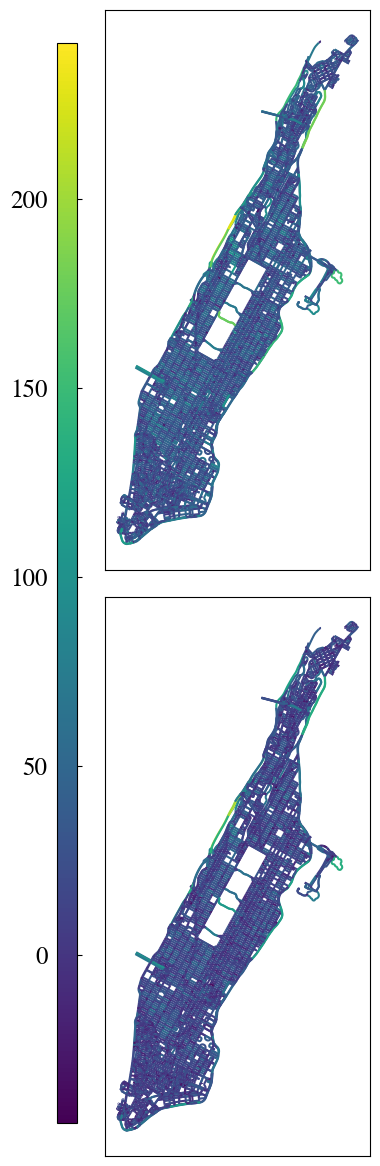

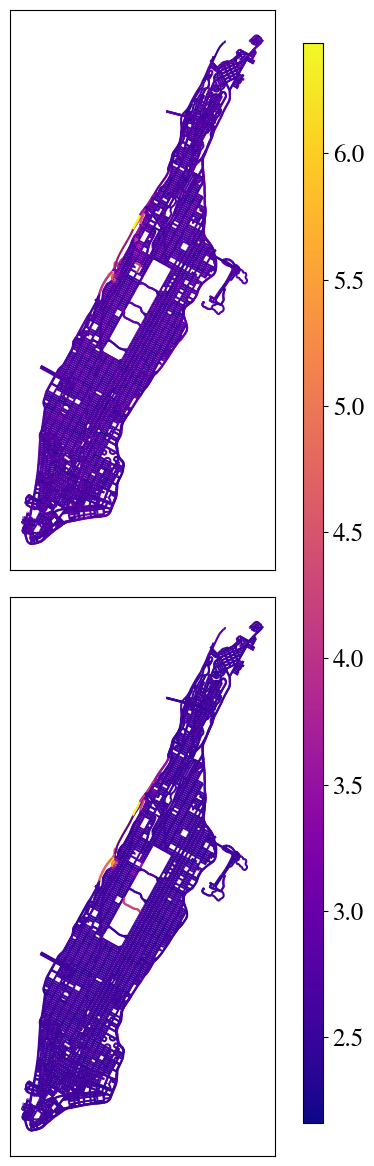

In [84]:
viz_attribute(regions_samples, position="left", cmap="viridis", fn="temp_rps.png")
viz_attribute(cluster_rp_vars, position="right", cmap="plasma", fn="temp_var.png")

In [85]:
from PIL import Image

images = [Image.open(x) for x in ["temp_rps.png", "temp_var.png"]]
widths, heights = zip(*(i.size for i in images))

total_width = sum(widths)
max_height = max(heights)

new_im = Image.new("RGB", (total_width, max_height))

x_offset = 0
for im in images:
    new_im.paste(im, (x_offset,0))
    x_offset += im.size[0]

new_im.save("weather_rps.png")